In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import plotly.express as px

# import required libraries for clustering
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree
from sklearn.preprocessing import StandardScaler, LabelEncoder

import warnings
warnings.filterwarnings('ignore')


In [2]:
df = pd.read_excel(r'C:\Users\PYTHON\InternSavy-Projects\Task\Online Retail.xlsx')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [3]:
df.shape

(541909, 8)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [5]:
df.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,541909.000000,541909,541909.000000,406829.000000
mean,9.552250,2011-07-04 13:34:57.156386048,4.611114,15287.690570
min,-80995.000000,2010-12-01 08:26:00,-11062.060000,12346.000000
25%,1.000000,2011-03-28 11:34:00,1.250000,13953.000000
50%,3.000000,2011-07-19 17:17:00,2.080000,15152.000000
75%,10.000000,2011-10-19 11:27:00,4.130000,16791.000000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000
std,218.081158,NaN,96.759853,1713.600303


In [6]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [7]:
# lets calculate the percentage of the missing values
missing_values = df.isna().sum()
total_rows = df.shape[0]
percentage_missing = (missing_values / total_rows) * 100
print(percentage_missing)

InvoiceNo       0.000000
StockCode       0.000000
Description     0.268311
Quantity        0.000000
InvoiceDate     0.000000
UnitPrice       0.000000
CustomerID     24.926694
Country         0.000000
dtype: float64


In [8]:
# let's drop rows having missing values
df = df.dropna()
df.shape

(406829, 8)

In [9]:
df['CustomerID'] = df['CustomerID'].astype(str)

## Feature engineering

In [10]:
# Monetary
df['total_price'] = df['Quantity']*df['UnitPrice']
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,total_price
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [11]:
# lets create rfm monetary for each customer
rfm_m = df.groupby('CustomerID')['total_price'].sum().reset_index()
rfm_m.head()

,CustomerID,total_price
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


In [12]:
# Frequency
# count the number of unique invoice numbers for each customer
rfm_f = df.groupby('CustomerID')['InvoiceNo'].count().reset_index()
rfm_f.rename(columns={'InvoiceNo':'Frequency'}, inplace=True)
rfm_f.head()

,CustomerID,Frequency
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


In [13]:
rfm_f.columns

Index(['CustomerID', 'Frequency'], dtype='object')

In [14]:
# Let's merge the two data frames
merged_rfm = rfm_m.merge(rfm_f, on='CustomerID')
merged_rfm.head()

,CustomerID,total_price,Frequency
0,12346.0,0.00,2
1,12347.0,4310.00,182
2,12348.0,1797.24,31
3,12349.0,1757.55,73
4,12350.0,334.40,17


In [15]:
# convert datetime to proper datatype
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'],format='%d-%m-%Y %H:%M')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,total_price
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [16]:
# To get the last transaction, we compute the maximum date in our data set
max_date = df['InvoiceDate'].nlargest(1).iloc[0]
print(max_date)

2011-12-09 12:50:00


In [17]:
# let's calculate the time difference for each record i.e recency
df['Diff'] = df['InvoiceDate'].max() - df['InvoiceDate']
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,total_price,Diff
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,373 days 04:24:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,373 days 04:24:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00


In [18]:
# to get recency, we compute last transaction date
rfm_p = df.groupby('CustomerID')['Diff'].min().reset_index()
rfm_p.head()

,CustomerID,Diff
0,12346.0,325 days 02:33:00
1,12347.0,1 days 20:58:00
2,12348.0,74 days 23:37:00
3,12349.0,18 days 02:59:00
4,12350.0,309 days 20:49:00


In [19]:
# let's extract the days only
rfm_p['Diff'] = pd.to_timedelta(rfm_p['Diff'])
rfm_p['Diff'] = rfm_p['Diff'].dt.days
rfm_p.head()

,CustomerID,Diff
0,12346.0,325
1,12347.0,1
2,12348.0,74
3,12349.0,18
4,12350.0,309


In [20]:
merged_rfm.head()

,CustomerID,total_price,Frequency
0,12346.0,0.00,2
1,12347.0,4310.00,182
2,12348.0,1797.24,31
3,12349.0,1757.55,73
4,12350.0,334.40,17


In [21]:
# we merge all the dataframes to get RFM dataframe
rfm_df = merged_rfm.merge(rfm_p, on='CustomerID')

rfm_df.rename(columns={'Diff':'Recency'}, inplace=True)
rfm_df.head()

,CustomerID,total_price,Frequency,Recency
0,12346.0,0.00,2,325
1,12347.0,4310.00,182,1
2,12348.0,1797.24,31,74
3,12349.0,1757.55,73,18
4,12350.0,334.40,17,309


*Let's check whether we have outliers*
We remove outliers because they distort analyses and models by introducing noise and skewing results


In [22]:
features = ['total_price', 'Frequency', 'Recency']
data = rfm_df[features]

# Box plot
fig = px.box(data, y=features, labels={'variable':'Features', 'value':'Range'},
             title = "Outliers Variable Distribution")
fig.update_layout(
    xaxis=dict(title="Features"),
    yaxis=dict(title="Range"),
    showlegend=False,
    boxmode='group', # Display box plots side by side
    width=800, height=600
)
fig.show()

In [23]:
# Removing outliers
# Total_price
Q1 = rfm_df.total_price.quantile(0.05)
Q3 = rfm_df.total_price.quantile(0.95)
IQR = Q3 - Q1
rfm_df = rfm_df[(rfm_df.total_price >= Q1 - 1.5*IQR) & (rfm_df.total_price <= Q3 + 1.5*IQR)]

# Recency
Q1 = rfm_df.Recency.quantile(0.05)
Q3 = rfm_df.Recency.quantile(0.95)
IQR = Q3 - Q1
rfm_df = rfm_df[(rfm_df.Recency >= Q1 - 1.5*IQR) & (rfm_df.Recency <= Q3 + 1.5*IQR)]

# Frequency
Q1 = rfm_df.Frequency.quantile(0.05)
Q3 = rfm_df.Frequency.quantile(0.95)
IQR = Q3 - Q1
rfm_df = rfm_df[(rfm_df.Frequency >= Q1 - 1.5*IQR) & (rfm_df.Frequency <= Q3 + 1.5*IQR)]


In [24]:
features = ['total_price','Frequency','Recency']

fig = px.box(rfm_df, y=features, title='Outliers Variable Distribution',
             labels = {'variable': 'Features','value':'Range'},
             boxmode='group', points='outliers')
fig.update_layout(
    xaxis=dict(title='Features', title_font=dict(size=14)),
    yaxis=dict(title='Range', title_font=dict(size=14)),
    showlegend=False,
    width=800,
    height=600
)
fig.show()

### Rescaling the Attributes
We will use Standardisation Scaling

In [25]:
rfm_df = rfm_df[['total_price','Frequency', 'Recency']]

# Instantiate
scaler= StandardScaler()

# fit_transform
rfm_df_scaled = scaler.fit_transform(rfm_df)
rfm_df_scaled.shape

(4293, 3)

In [26]:
rfm_df_scaled = pd.DataFrame(rfm_df_scaled)
rfm_df_scaled.columns = ['total_price','Frequency','Recency']
rfm_df_scaled.head()

,total_price,Frequency,Recency
0,-0.723738,-0.752888,2.301611
1,1.731617,1.042467,-0.906466
2,0.300128,-0.463636,-0.183658
3,0.277517,-0.044720,-0.738141
4,-0.533235,-0.603275,2.143188


### Building the Model
*K-Means Clustering*
The primary goal is to group similar data points together and discover natural patterns or structure within the data without any prior knowledge of the groups


In [27]:
# K-means with some arbitrary k
kmeans = KMeans(n_clusters=4, max_iter=50)
kmeans.fit(rfm_df_scaled)

KMeans(max_iter=50, n_clusters=4)

In [28]:
kmeans.labels_

array([2, 3, 1, ..., 2, 1, 1])

## Finding the Optimal NUmber of Clusters
We will use the Elbow Curve to get the right number of Clusters


In [29]:
ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    ssd.append(kmeans.inertia_)
    print("For n_clusters={0}, the Elbow score is {1}".format(num_clusters, kmeans.inertia_))
    
fig = px.line(x=range_n_clusters, y=ssd,
              title="Elbow Curve for K-Means Clustering",
              labels={'x': 'Number of Clusters', 'y':'Sum of Squared Distances (SSD)'})

fig.update_layout(
    xaxis=dict(title_font=dict(size=14)),
    yaxis=dict(title_font=dict(size=14)),
    showlegend=False,
    width=800,
    height=600
)

fig.show()

For n_clusters=2, the Elbow score is 7661.7058693207455
For n_clusters=3, the Elbow score is 4433.58061930212
For n_clusters=4, the Elbow score is 3360.5727756941005
For n_clusters=5, the Elbow score is 2802.8241284834685
For n_clusters=6, the Elbow score is 2392.2371699665596
For n_clusters=7, the Elbow score is 2038.5685803422894
For n_clusters=8, the Elbow score is 1827.2459955963452


In [30]:
ssd

[7661.7058693207455,
 4433.58061930212,
 3360.5727756941005,
 2802.8241284834685,
 2392.2371699665596,
 2038.5685803422894,
 1827.2459955963452]

## Silhoutte Analysis
A score closer to 1 indicateds that the data point is very similar to the other data points inthe cluster

A score closer to -1 indicates that the data point is not similar to the data points in the cluster

This is going to help us select the number that provides the best clustering quality for our data

In [31]:
# Silhoutte analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    # initialize kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    
    kmeans.fit(rfm_df_scaled)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(rfm_df_scaled, cluster_labels)
    print("For n_clusters={0}, the silhoutte score is {1}".format(num_clusters, silhouette_avg))
    
    

For n_clusters=2, the silhoutte score is 0.5415858652525395
For n_clusters=3, the silhoutte score is 0.5084896296141937
For n_clusters=4, the silhoutte score is 0.4777820100216849
For n_clusters=5, the silhoutte score is 0.46627005641897035
For n_clusters=6, the silhoutte score is 0.41698547252648926
For n_clusters=7, the silhoutte score is 0.4147649184802503
For n_clusters=8, the silhoutte score is 0.4087585527986688


*The silhoutte Score* measures the quality of the clusters
Higher silhoutte score indicates better separation and cohesion of clusters. In our case its 2 clusters(0.5416) and the second is 3 clusters(0.5085) which is quite good

*The elbow point* looks at the reduction in error which in our case occurs at 3 clusters. This is where the reduction error starts to slow down significantly
Hence  we will choose 3 clusters


In [32]:
# Final model with k=3
kmeans = KMeans(n_clusters=3,max_iter=50)
kmeans.fit(rfm_df_scaled)

KMeans(max_iter=50, n_clusters=3)

In [33]:
kmeans.labels_

array([2, 1, 0, ..., 2, 0, 0])

In [34]:
# assign the label
rfm_df['Cluster_Id'] = kmeans.labels_
rfm_df.head()

,total_price,Frequency,Recency,Cluster_Id
0,0.00,2,325,2
1,4310.00,182,1,1
2,1797.24,31,74,0
3,1757.55,73,18,0
4,334.40,17,309,2


In [37]:
fig = px.box(rfm_df, x='Cluster_Id', y='total_price',
             title="Cluster Id vs Total Price Box Plot",
             labels={'Cluster_Id': 'Cluster ID', 'total_price':'total_price'},
             color='Cluster_Id')

fig.update_layout(
    xaxis=dict(title='Cluster ID', title_font=dict(size=14)),
    yaxis=dict(title='total_price', title_font=dict(size=14)),
    showlegend=False,
    width=800,
    height=600
)

fig.show()

In [39]:
fig = px.scatter(rfm_df, x='Cluster_Id', y='total_price', color='Frequency',
                 title='Cluster ID vs Total Price(Color Encoded by Frequency)',
                 labels={'Cluster_Id':'Cluster ID','total_price':'Total Price', 'Frequency':'Frequency'})

fig.update_layout(
    xaxis=dict(title="Cluster ID", title_font=dict(size=14)),
    yaxis=dict(title="Total Price", title_font=dict(size=14)),
    showlegend=True,
    width=800,
    height=600
)
fig.show()

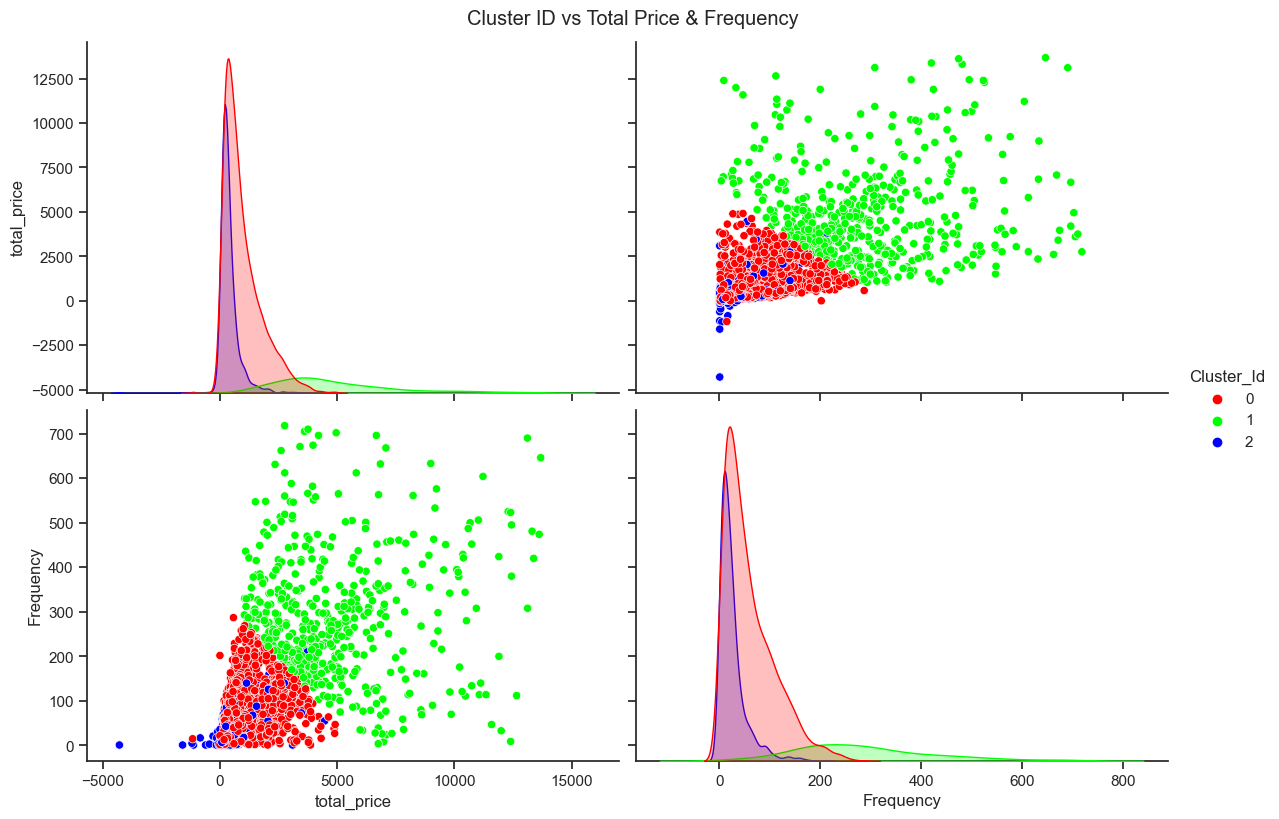

In [41]:
# Create a custom palette with Red, Green, and Blue
custom_palette = sns.color_palette(["#FF0000", "#00FF00", "#0000FF"])

# Create a scatter plot matrix with separate plots for each cluster, custome palette, and a larger size
sns.set(style="ticks")
sns.pairplot(rfm_df, hue='Cluster_Id', vars=['total_price', 'Frequency'], palette=custom_palette, height=4, aspect=1.5)
plt.suptitle('Cluster ID vs Total Price & Frequency', y=1.02)
plt.show()


In [42]:
# Box plot to visualize Cluster Id vs Frequency
fig = px.box(rfm_df, x='Cluster_Id', y='Frequency',
             title = "Cluster Id vs Frequency Box Plot",
             labels={'Cluster_Id':'Cluster Id', 'Frequency':'Frequency'})

fig.update_layout(
    xaxis=dict(title="Cluster ID", title_font=dict(size=14)),
    yaxis=dict(title="Frequency", title_font=dict(size=14)),
    showlegend=False,
    width=800,
    height=600
)

fig.show()

In [43]:
# Box plot to visualize Cluster ID vs Recency
fig = px.box(rfm_df, x='Cluster_Id', y='Recency',
             title='Cluster Id vs Recency Box Plot',
             labels= {'Cluster_Id':'Cluster Id', 'Recency':'Recency'})

fig.update_layout(
     xaxis=dict(title="Cluster ID", title_font=dict(size=14)),
    yaxis=dict(title="Recency", title_font=dict(size=14)),
    showlegend=False,
    width=800,
    height=600
)

In [44]:
# Selecting the two features for clustering
clustering_data = rfm_df[['total_price', 'Frequency']]

# Specify the number of clusters (e.g., 3)
n_clusters = 3

# Apply K-Means clustering
kmeans = KMeans(n_clusters=n_clusters)
rfm_df['Cluster_2D'] = kmeans.fit_predict(clustering_data)

# Scatter plot
fig = px.scatter(rfm_df, x='total_price', y='Frequency', color='Cluster_2D',
                 title='Clustering by Total Price and Frequency',
                 labels={'total_price':'Total Price', 'Frequency':'Frequency', 'Cluster_2D':'Cluster'})

fig.update_layout(
    xaxis=dict(title='Total Price', title_font=dict(size=14)),
    yaxis=dict(title='Frequency', title_font=dict(size=14)),
    width=800,
    height=600
)
fig.show()

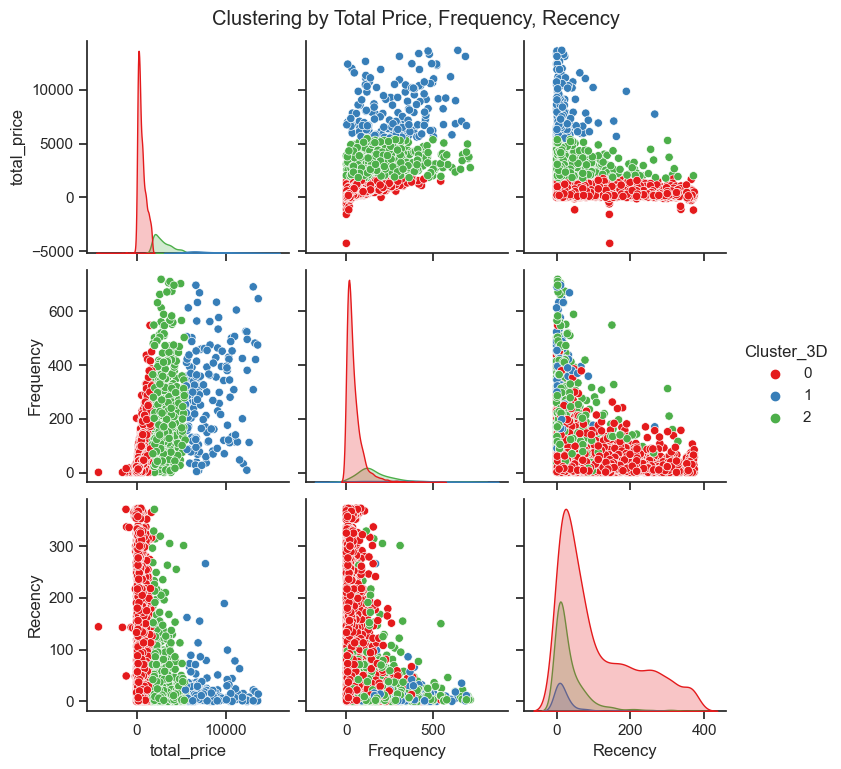

In [45]:
clustering_data = rfm_df[['total_price','Frequency', 'Recency']]

# Apply K-Means clustering
kmeans = KMeans(n_clusters=n_clusters)
rfm_df['Cluster_3D'] = kmeans.fit_predict(clustering_data)

# Scatter plot matrix
sns.set(style="ticks")
sns.pairplot(rfm_df, hue='Cluster_3D', vars=['total_price', 'Frequency', 'Recency'], palette='Set1')
plt.suptitle('Clustering by Total Price, Frequency, Recency', y=1.02)
plt.show()

In [46]:
import plotly.express as px

# Apply K-Means clustering
kmeans = KMeans(n_clusters=n_clusters)
rfm_df['Cluster_3D'] = kmeans.fit_predict(clustering_data)

# 3D scatter plot matrix with plotly
fig = px.scatter_3d(rfm_df, x='total_price',y='Frequency', z='Recency', color='Cluster_3D',
                    labels={'total_price':'Total Price', 'Frequency':'Frequency', 'Recency':'Recency', 'Cluster_3D':'Cluster'})

fig.update_layout(
    scene=dict(
        xaxis_title='Total Price',
        yaxis_title='Frequency',
        zaxis_title='Recency'
    ),
    title='Clustering by Total Price, Frequency, and Recency',
    width=800,
    height=600
)
fig.show()

### Hierarchichal Clustering
**Types of hierarchical clutering**
* Divisive
* Agglomerative
* Single Linkage
In single linkage hierarchical clustering, the distance between two clusters is defined as the shortest distance between two points in each cluster. This distance is known as euclidean distance

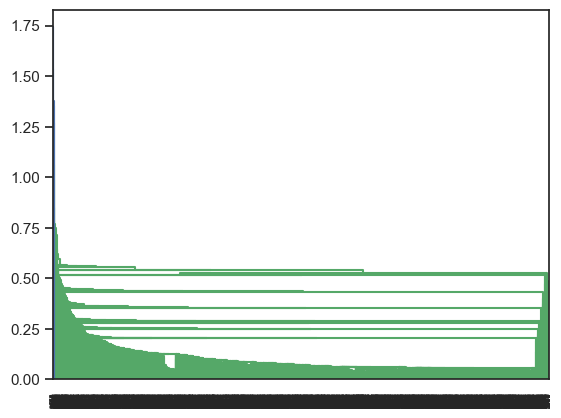

In [47]:
# Single linkage:
mergings = linkage(rfm_df_scaled, method="single", metric='euclidean')
dendrogram(mergings)
plt.show()

**Complete Linkage**

The distance between two clusters is defined as the longest disatnce between two point in each cluster

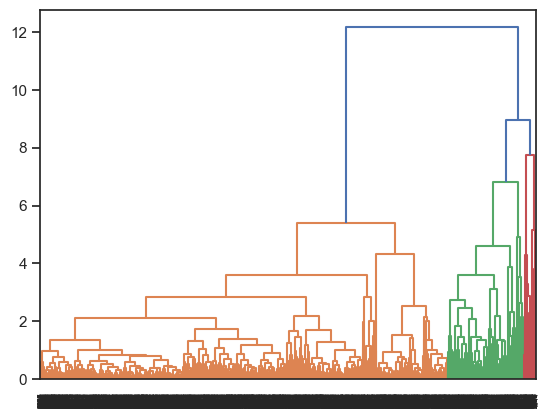

In [48]:
# Complete linkage
mergings = linkage(rfm_df_scaled, method="complete", metric='euclidean')
dendrogram(mergings)
plt.show()

**Average Linkage:**

The distance between two clusters is defined as the average distance each point in the other cluster 

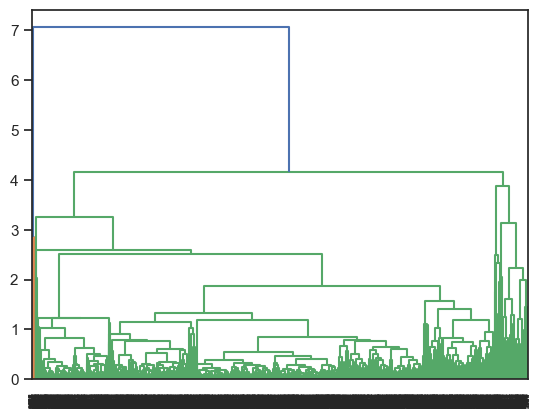

In [50]:
# Average linkage
mergings = linkage(rfm_df_scaled, method="average", metric='euclidean')
dendrogram(mergings)
plt.show()

**Cutting the Dendrogram based on K**

In [51]:
# 3 clusters
cluster_labels = cut_tree(mergings, n_clusters=3).reshape(-1, )
cluster_labels

array([0, 0, 0, ..., 0, 0, 0])

In [52]:
# Assign cluster labels
rfm_df['Cluster_Labels'] = cluster_labels
rfm_df.head()

,total_price,Frequency,Recency,Cluster_Id,Cluster_2D,Cluster_3D,Cluster_Labels
0,0.00,2,325,2,0,0,0
1,4310.00,182,1,1,2,2,0
2,1797.24,31,74,0,2,2,0
3,1757.55,73,18,0,2,2,0
4,334.40,17,309,2,0,0,0


In [54]:
fig = px.box(rfm_df, x='Cluster_Labels', y='total_price',
             title="Cluster Labels vs Total Price Box Plot",
             labels={'Cluster_Labels':'Cluster Labels', 'total_price':'Total Price'})

fig.update_layout(
    xaxis=dict(title="Cluster Labels", title_font=dict(size=14)),
    yaxis=dict(title="Total price", title_font=dict(size=14)),
    showlegend=False,
    width=800,
    height=600
)

fig.show()

In [56]:
fig = px.box(rfm_df, x='Cluster_Labels', y='Frequency',
             title="Cluster Labels vs Frequency Box Plot",
             labels={'Cluster_Labels':'Cluster Labels', 'Frequency':'Frequency'})

fig.update_layout(
    xaxis=dict(title="Cluster Labels", title_font=dict(size=14)),
    yaxis=dict(title="Frequency", title_font=dict(size=14)),
    showlegend=False,
    width=800,
    height=600
)

fig.show()

In [57]:
fig = px.box(rfm_df, x='Cluster_Labels', y='Recency',
             title="Cluster Labels vs Recency Box Plot",
             labels={'Cluster_Labels':'Cluster Labels', 'Recency':'Recency'})

fig.update_layout(
    xaxis=dict(title="Cluster Labels", title_font=dict(size=14)),
    yaxis=dict(title="Recency", title_font=dict(size=14)),
    showlegend=False,
    width=800,
    height=600
)

fig.show()

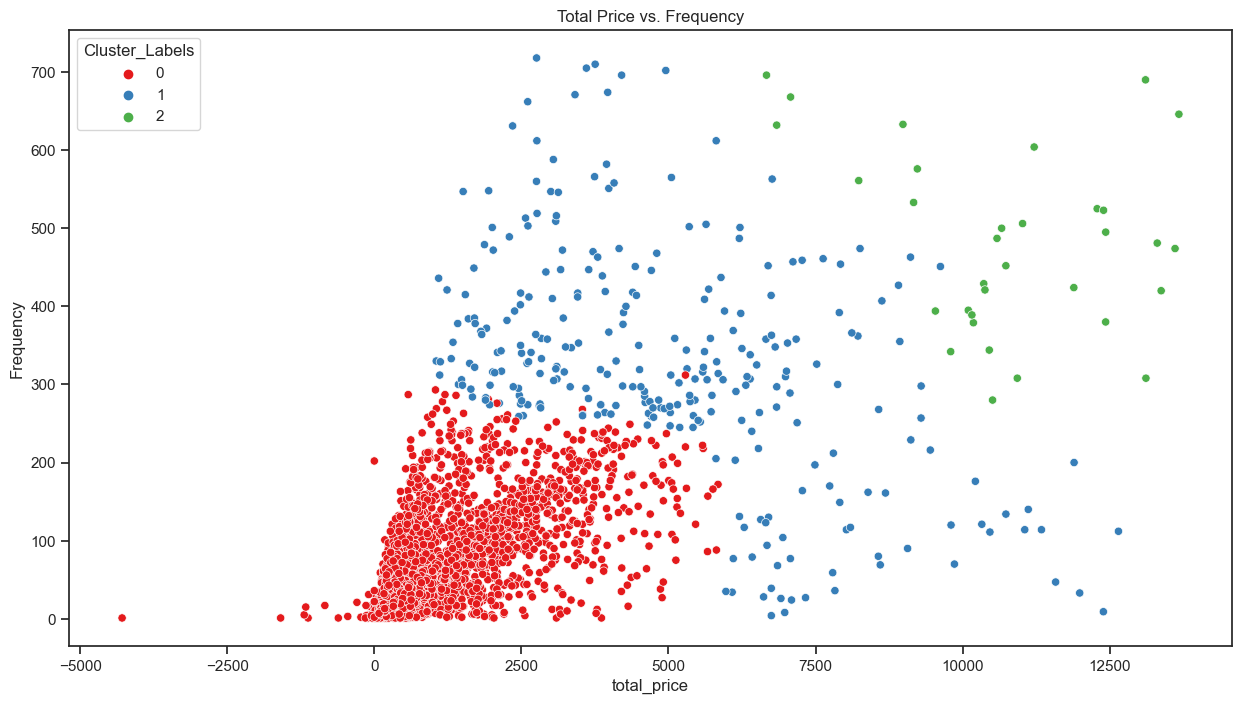

In [58]:
# Pairwise scatter plots for clustering (2D)
plt.figure(figsize=(15, 8))

sns.scatterplot(x='total_price', y='Frequency', hue='Cluster_Labels', data=rfm_df, palette='Set1')
plt.title('Total Price vs. Frequency');


In [ ]:
# Pairwise scatter plots for clustering (2D)
plt.figure(figsize=(15, 8))

sns.scatterplot(x='total_price', y='Recency', hue='Cluster_Labels', data=rfm_df, palette='Set1')
plt.title('Total Price vs. ');